# Algorithmen zur Price Anomaly Detection als Beispiel an der Tesla Aktie




![title](tesla2.png)

Tesla ist ein amerikanisches Unternehmen, welches im Jahre 2003 von den Ingenieuren Martin Eberhard und Marc Tarpenning gegründet wurde. Das amerikanische Unternehmen beschäftigt sich mit der Entwicklung, Produktion und Vermarktung von Elektrofahrzeugen, sowie Batterieprodukten und Solarenergieprodukten. 2004 steigte Elon Musk als Investor in das Unternehmen ein.
Als CEO von Tesla ist Elon Musk für die gesamte Produktentwicklung, das Engineering und die weltweite Herstellung verantwortlich.
Ende Juni 2010 brachte Elon Musk sein amerikanisches Unternehmen Tesla an die Börse.

In unserem Projekt untersuchen wir den Marktkurs der Teslaaktien auf Anomalien.

Anomalien oder Ausreißer (engl. „outlier“) sind Datenpunkte deren Ausprägungen sich signifikant von der Merkmalsverteilung der restlichen Datenpunkte unterscheiden. 

Die Erkennung von Anomalien (engl. „Anomaly Detection“) ist ein Schritt im Data Mining, der Datenpunkte, Ereignisse und/oder Beobachtungen identifiziert, die vom normalen Verhalten eines Datensatzes abweichen. Maschinelles Lernen wird zunehmend eingesetzt, um die Erkennung von Anomalien zu automatisieren.

Ein entscheidender Vorteil einer auf Machine-Learning-Algorithmen basierenden Anomalieerkennung ist es, dass man nicht mehr bloß mit einfachen Grenzwerten arbeitet, die normale Datenpunkte von Ausreißern unterscheiden. Unter anderem werden bspw. auch saisonale Schwankungen erkannt. 

# Gliederung
#### 1. Datenanalyse
#### 2. Analyse der Datenstruktur
#### 3. K-Means Algorithmus
#### 4. Isolation Forest
#### 5. Support Vector Machine (SVM)
#### 6. Long Short Term Memory (LSTM)
#### 7. Vergleich der identifizierten Anomalien

In [330]:
import pandas            as pd
import pandasql          as psql
import numpy             as np
import os
import datetime
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import tensorflow as tf

sns.set(style='whitegrid', palette='muted')

from   IPython.core.display           import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
print()

script_dir = os.getcwd()

<hr>

# 1. Datenanalyse

Die Datenquelle für den Aktienkurs ist die folgende Website: 
[Stock Data](https://finance.yahoo.com/quote/TSLA/history?period1=1277769600&period2=1609977600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [331]:
print('Read in Tesla data')
print()
df = pd.read_csv(script_dir +'/TSLA.CSV/')

Read in Tesla data



In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2637 non-null   object 
 1   Open       2637 non-null   float64
 2   High       2637 non-null   float64
 3   Low        2637 non-null   float64
 4   Close      2637 non-null   float64
 5   Adj Close  2637 non-null   float64
 6   Volume     2637 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 144.3+ KB


###### Bedeutung der Spalten:

     'High'     : - Höchster Preis während des Tages
     'Low'      : - Niedrigster Preis während des Tages
     'Open"     : - Eröffnungskurs des Tages
     'Close"    : - Schlusskurs des Tages
     'Volume'   : - Gesamtzahl der Aktien, die während des Tages gehandelt wurden
     'Adj Close": - Geänderter Schlusskurs, in dem Kapitalmaßnahmen berücksichtigt werden

In [333]:
df['Date'] = pd.to_datetime(df['Date'])

In [334]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2.637000e+03
mean,58.485060,59.784425,57.132463,58.545375,58.545375,3.047029e+07
std,85.617517,87.994983,83.088473,85.869828,85.869828,2.823043e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,7.400000,7.588000,7.336000,7.408000,7.408000,1.067400e+07
50%,44.402000,45.098000,43.672001,44.341999,44.341999,2.398900e+07
75%,60.400002,61.518002,59.299999,60.554001,60.554001,3.954800e+07
max,653.690002,654.320007,623.799988,649.880005,649.880005,3.046940e+08


In [335]:
print('Check for missing values')
df.isnull().sum()
print()
print('Time duration stock data')
df['Date'].max() - df['Date'].min()

Check for missing values

Time duration stock data


Timedelta('3823 days 00:00:00')




Setze das Datum als den Index : 

In [336]:
df.index = df['Date']
#df = df.set_index('Date')

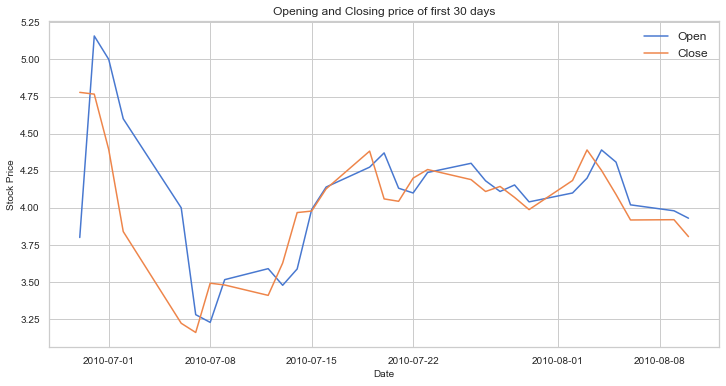

In [337]:
plt.figure(figsize = (12,6)) # Adjusting figure size
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Date',fontsize = 10)
plt.ylabel('Stock Price',fontsize = 10)
plt.plot(df.iloc[0:30]['Open'],label = 'Open') # Opening prices of first 30 days are plotted against date
plt.plot(df.iloc[0:30]['Close'],label = 'Close') # Closing prices of first 30 days are plotted against date
plt.legend(loc='upper right', frameon=False,framealpha=1,prop={'size': 12}) # Properties of legend box
plt.title('Opening and Closing price of first 30 days');

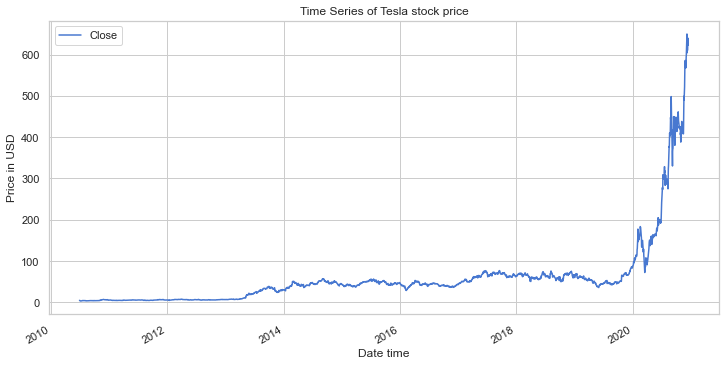

In [338]:
df.plot(x='Date', y='Close', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of Tesla stock price');

Es ist deutlich zu erkennen, dass der Aktienkurs gerade im letzten Jahr extrem in die Höhe geschossen ist.
Wir schauen uns im Folgenden einmal die Differenz des Open - und Close - Aktienkurses an.

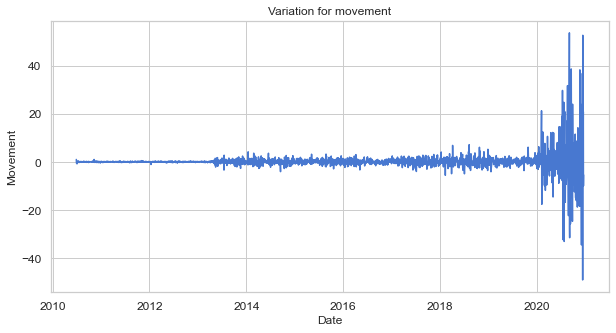

In [339]:
stock_open = np.array(df['Open']).T # stock_open is numpy array of transpose of df['Open']
stock_close = np.array(df['Close']).T # stock_close is numpy array of transpose of df['Close']
movements = stock_close - stock_open

plt.figure(figsize = (10,5)) 
plt.title('Variation for movement',fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Movement',fontsize = 12)
plt.plot(df.Date, movements)

Diese Differenz schwankt im Jahr 2020 besonders stark. 
In der folgenden Grafik wird das Volumen der gehandelten Tesla Aktien betrachtet.

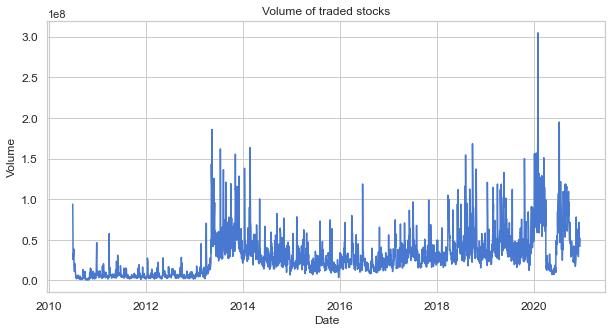

In [340]:
plt.figure(figsize = (10,5)) 
plt.title('Volume of traded stocks',fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Volume',fontsize = 12)
plt.plot(df.Date, df.Volume)

Wir berechnen nun einmal die prozentuale Schwankung des Aktienkurses im Vergleich zum Vortag.

Im Folgenden werden wir stellvertretend für den Aktienkurs den Close Preis betrachten.

<AxesSubplot:title={'center':'Day-to-day percentage change'}, xlabel='Date'>

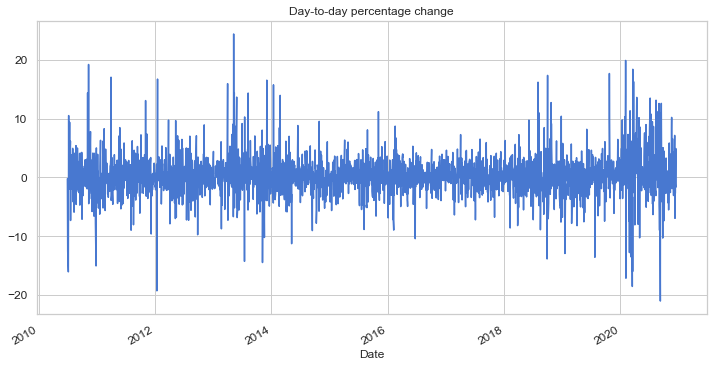

In [341]:
df['Day_Perc_Change'] = df['Close'].pct_change()*100
df.head()
plt.title('Day-to-day percentage change',fontsize = 12)
df.dropna(axis = 0, inplace = True)
df['Day_Perc_Change'].plot(figsize = (12, 6), fontsize = 12)

#### Trend Analysis Overview

In [342]:
def trend(x):
    if x > -0.5 and x <= 0.5:
        return 'Slight or No change'
    elif x > 0.5 and x <= 1:
        return 'Slight Positive'
    elif x > -1 and x <= -0.5:
        return 'Slight Negative'
    elif x > 1 and x <= 10:
        return 'Positive'
    elif x > -10 and x <= -1:
        return 'Negative'
    elif x > 10:
        return 'Strong Positive'
    elif x <= -10:
        return 'Strong Negative'
df['Trend']= np.zeros(df['Day_Perc_Change'].count())
df['Trend']= df['Day_Perc_Change'].apply(lambda x:trend(x))

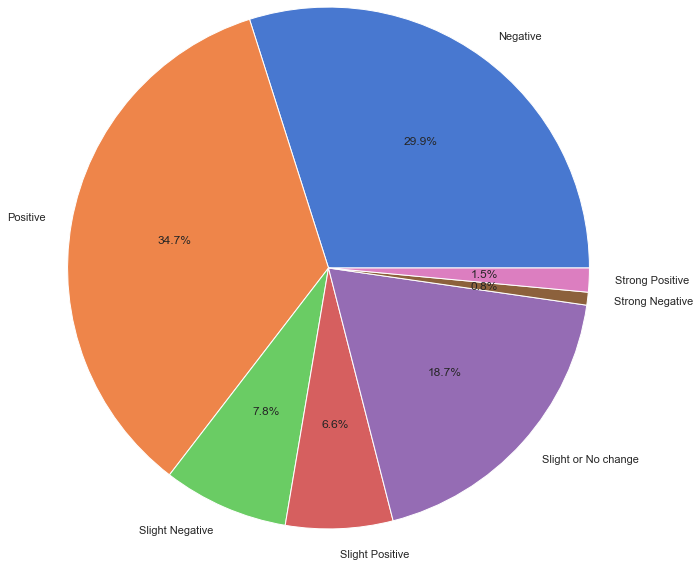

In [343]:
df_pie_data = df.groupby('Trend')
pie_label = sorted([i for i in df.loc[:, 'Trend'].unique()])
plt.pie(df_pie_data['Trend'].count(), labels = pie_label, 
        autopct = '%1.1f%%', radius = 3)

plt.show()

In [344]:
df['anomaly'] = np.where((df.Trend=='Strong Positive') | (df.Trend=='Strong Negative') , 1, 0)

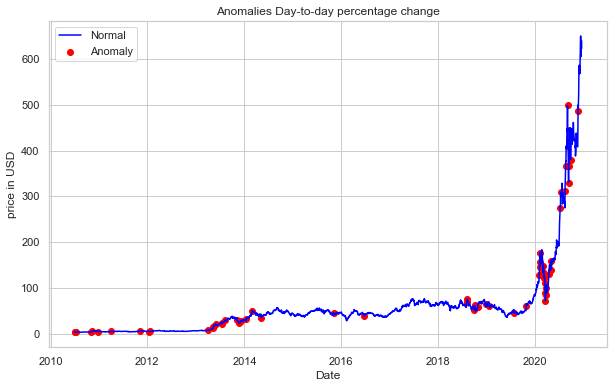

In [345]:
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == 1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label='Normal')
ax.scatter(a['Date'],a['Close'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('price in USD')
plt.title('Anomalies Day-to-day percentage change',fontsize = 12)

plt.legend()
plt.show();

In dem obigen Graphen sind die Aktienkurse markiert, die im Vergleich zum Vortag um 10 % gestiegen oder gesunken sind.

<hr>

# 2. Analyse der Datenstruktur

Zunächst fügen wir an den Datensatz pro Eintrag eine Spalte für das Jahr, den Monat und den Wochentag hinzu, um danach eventuelle Perioden zu erkennen.

In [346]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
# Display a random sampling of 5 rows
df.sample(5, random_state=0)

,Date,Open,High,Low,Close,Adj Close,Volume,Day_Perc_Change,Trend,anomaly,Year,Month,Weekday
Date,,,,,,,,,,,,,
2010-11-09,2010-11-09,5.000,5.138000,4.810000,4.926000,4.926000,4782000,-1.401121,Negative,0,2010,11,1
2019-09-18,2019-09-18,49.000,49.633999,48.473999,48.698002,48.698002,20851000,-0.531063,Slight Negative,0,2019,9,2
2012-08-01,2012-08-01,5.598,5.598000,5.206000,5.250000,5.250000,7961500,-4.266958,Negative,0,2012,8,2
2012-03-26,2012-03-26,7.118,7.618000,7.008000,7.480000,7.480000,15702500,9.741784,Positive,0,2012,3,0
2010-12-15,2010-12-15,5.734,5.994000,5.706000,5.920000,5.920000,3714500,3.750438,Positive,0,2010,12,2


### Saisonalität

Text(0.5, 1.0, 'Stock Price in 2017')

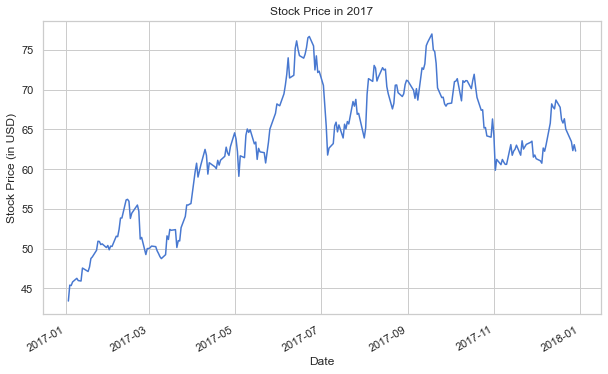

In [347]:
ax = df.loc['2017', 'Close'].plot(figsize=(10, 6))
ax.set_ylabel('Stock Price (in USD)')
plt.title('Stock Price in 2017',fontsize = 12)

Text(0.5, 1.0, 'Stock Price in first two month of 2017')

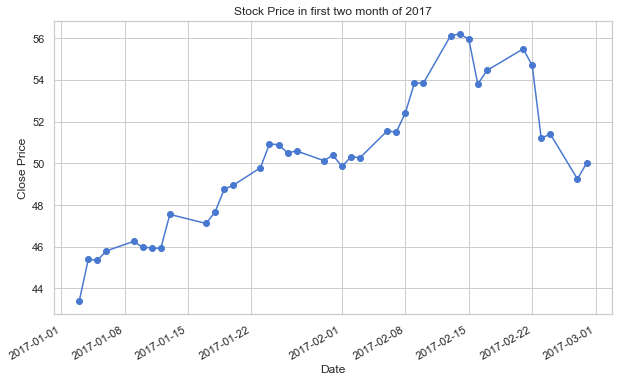

In [348]:
ax = df.loc['2017-01':'2017-02', 'Close'].plot(marker='o', linestyle='-', figsize=(10, 6))
ax.set_ylabel('Close Price')
plt.title('Stock Price in first two month of 2017',fontsize = 12)

Es lässt sich anhand der Daten auf den ersten Blick keine Periode erkennen. Weder auf das Jahr, noch auf den Monat betrachtet. Daher untersuchen wir im Anschluss die Saisonalität.

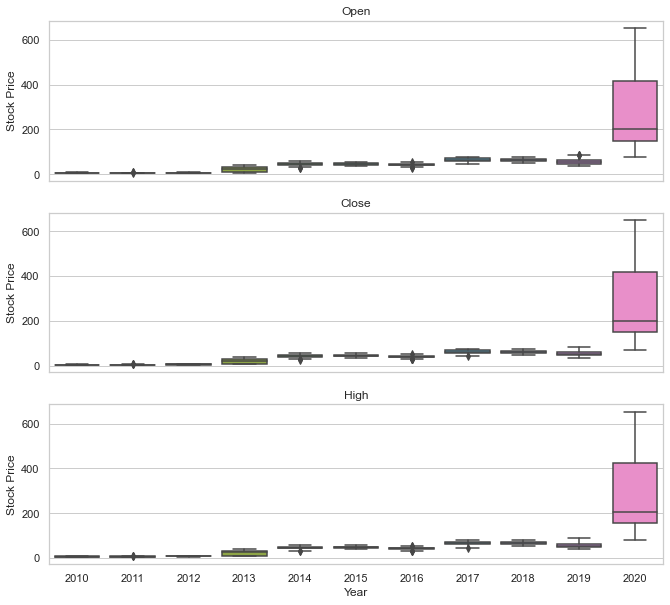

In [349]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Open', 'Close', 'High'], axes):
    sns.boxplot(data=df, x='Year', y=name, ax=ax)
    ax.set_ylabel('Stock Price')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

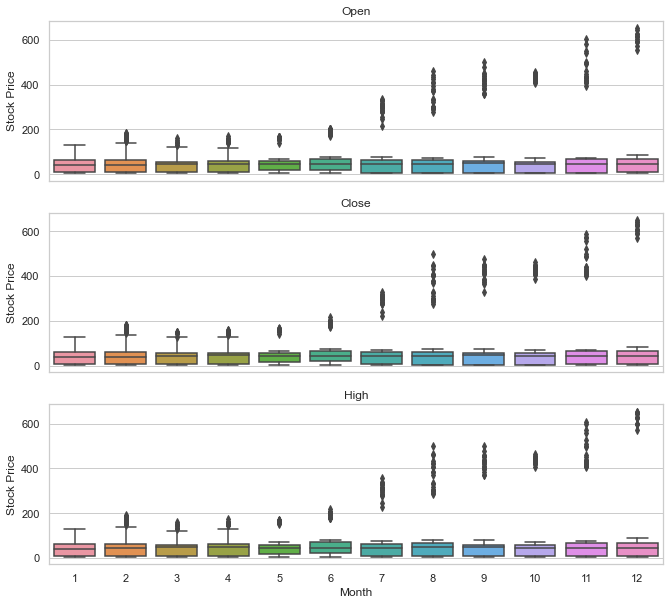

In [350]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Open', 'Close', 'High'], axes):
    sns.boxplot(data=df, x='Month', y=name, ax=ax)
    ax.set_ylabel('Stock Price')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

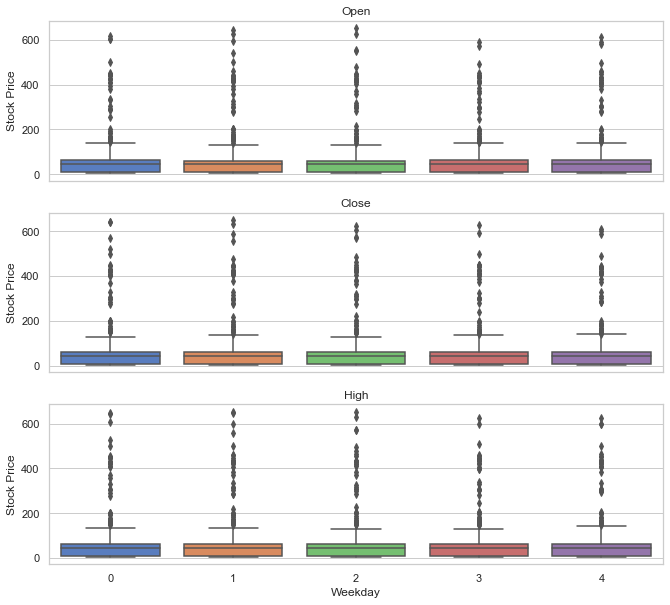

In [351]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Open', 'Close', 'High'], axes):
    sns.boxplot(data=df, x='Weekday', y=name, ax=ax)
    ax.set_ylabel('Stock Price')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

###  Frequencies

In [352]:
df.index

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2020-12-03', '2020-12-04', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-14',
               '2020-12-15', '2020-12-16'],
              dtype='datetime64[ns]', name='Date', length=2636, freq=None)

Wir sehen, dass keine Frequency gegeben ist (freq=None). Das macht sinn, da der Index aus den Daten in der CSV Datei erzeugt wurde, ohne eine spezielle Frequenz für die Zeitreihe anzugeben. 

Im Folgenden betrachten wir einmal den durchschnittlichen Aktienkurs pro Woche. Dafür resamplen wir den wöchentlichen Durchschnitt mit der Downsampling-Methode:

In [353]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Open', 'Close', 'High']
# Resample to weekly frequency, aggregating with mean
df_weekly_mean = df[data_columns].resample('W').mean() # W: weekly
df_weekly_mean.head(3)

,Open,Close,High
Date,,,
2010-07-04,4.919333,4.332667,5.2960
2010-07-11,3.506000,3.338500,3.6025
2010-07-18,3.756800,3.822400,3.9864


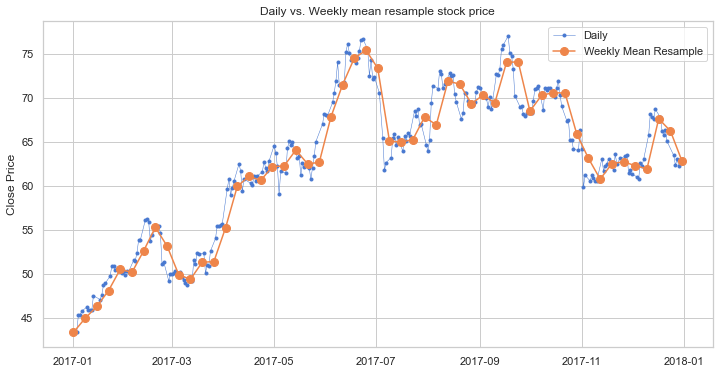

In [354]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-12'

# Plot daily and weekly resampled time series together

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df.loc[start:end, 'Close'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_weekly_mean.loc[start:end, 'Close'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Close Price')
ax.set_title('Daily vs. Weekly mean resample stock price')

ax.legend();

Es ist zu erkennen, dass die wöchentliche Mittelwert-Zeitreihe glatter ist als die tägliche Zeitreihe.

### Rolling Windows

Rolling-Window-Operationen sind eine weitere wichtige Transformation für Zeitreihendaten. Rolling Windows teilen die Daten in Zeitfenster auf und die Daten in jedem Fenster werden mit einer Funktion wie mean(), median(), sum() aggregiert. Im Gegensatz zum Downsampling, bei dem sich die Zeitfenster nicht überlappen und die Ausgabe eine niedrigere Frequenz als die Eingabe hat, überlappen sich die Rolling Windows und "rollen" mit der gleichen Frequenz wie die Daten weiter, so dass die transformierte Zeitreihe die gleiche Frequenz wie die ursprüngliche Zeitreihe hat.

In [355]:
# Compute the centered 7-day rolling mean
df_5d = df[data_columns].rolling(5, center=True).mean()
df_10d = df[data_columns].rolling(10, center=True).mean()

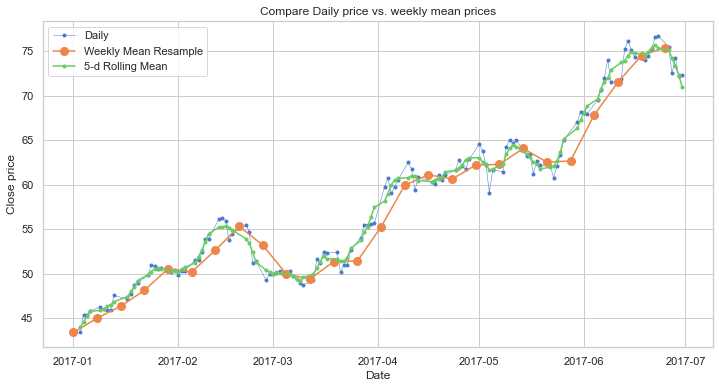

In [356]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 5-day rolling mean time series together
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df.loc[start:end, 'Close'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_weekly_mean.loc[start:end, 'Close'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(df_5d.loc[start:end, 'Close'],
marker='.', linestyle='-', label='5-d Rolling Mean')
ax.set_ylabel('Close price')
ax.set_xlabel('Date')

ax.set_title('Compare Daily price vs. weekly mean prices')
ax.legend();

Im nächsten Schritt werden die Durchschnitte der letzten 5 und 10 Tage an unseren Datensatz gemergt

In [357]:
df = df.reset_index(drop=True)
df_5d = df_5d.rename({'Close' : 'Close_5d'}, axis = 1)
df_5d.reset_index(level=0, inplace=True)
df = df.merge(df_5d[['Date', 'Close_5d']], how = 'left', on = 'Date')
df_10d = df_10d.rename({'Close' : 'Close_10d'}, axis = 1)
df_10d.reset_index(level=0, inplace=True)
df = df.merge(df_10d[['Date', 'Close_10d']], how = 'left', on = 'Date')
df.dropna(subset = ["Close_5d", 'Close_10d'], inplace=True)

Text(0.5, 0, 'Date')

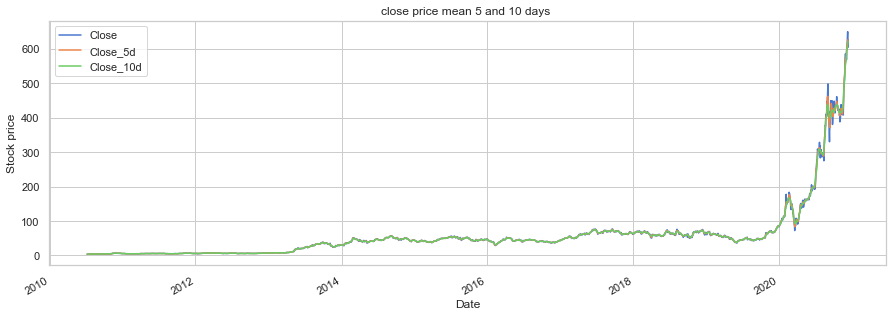

In [358]:
fig, ax = plt.subplots(figsize = (15, 5))
df.plot(x = 'Date', y = ['Close', 'Close_5d', 'Close_10d'], ax = ax)
ax.set_title('close price mean 5 and 10 days ')
ax.set_ylabel('Stock price')
ax.set_xlabel('Date')


<hr>

# 3. K-Means Algorithmus

Der k-means Algorithmus ist ein beliebter Clustering-Algorithmus. Er bietet eine einfache und schnelle Möglichkeit für eine gegebene Anzahl von Klassen / Clustern K, eine ”optimale“
Aufteilung der n Objekte/Beobachtungen in diese K Klassen zu finden.  Eine optimale Partition wird ausgeführt, wenn die Beobachtungen innerhalb einer Klasse sehr ähnlich sind, aber die Beobachtungen zwischen den verschiedenen Klassen sich möglichst stark unterscheiden. Er zeichnet sich unter anderem dadurch aus, dass die Anzahl der zu bildenden Cluster im Voraus manuell festgelegt werden muss.

![title](kmeans2.png)

Zu Beginn legen wir die Anzahl K von Clustern fest, in die wir die Datenpunkte einteilen möchten. Diese lesen wir von der Elbow Kurve ab.
Bei dem K-Means Cluster-Algorithmus werden 3 Schritte durchgeführt:
1.	Es werden K Clusterzentren gewählt und zufällig im Datenraum verteilt.
2.	Es wird jede Beobachtung zu einem Cluster zugeordnet. Der Algorithmus gliedert die Beobachtungen zu den Zentren ein, die am nähesten liegt, indem Sie den euklidischen Abstand berechnet.
3.	Eine Neuberechnung der Clusterzentren wird durchgeführt, indem sie so unterteilt werden, dass die Summe der quadrierten Distanz minimal ist.

Das Verfahren wird beendet, entweder nach einer zu Beginn festgelegten Anzahl an Iterationen (Durchläufen), oder wenn sich in einem Durchgang die Zuordnung in die Cluster nicht mehr verändert.

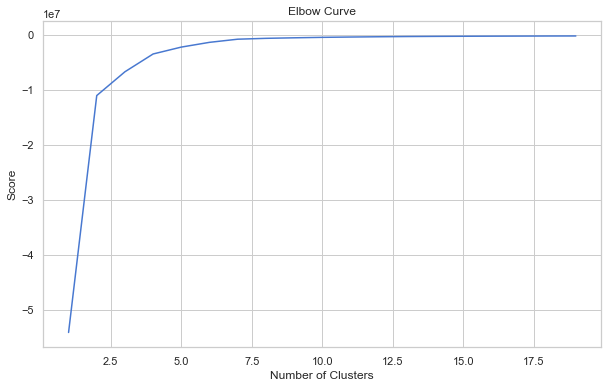

In [359]:
data = df[['Close', 'Close_5d','Close_10d']]
data = data.dropna()
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

Wir setzen in dem folgenden Modell die Zahl der Cluster auf 7, da sich das Modell mit einer höheren Clusterzahl nicht signifikant verbessert.

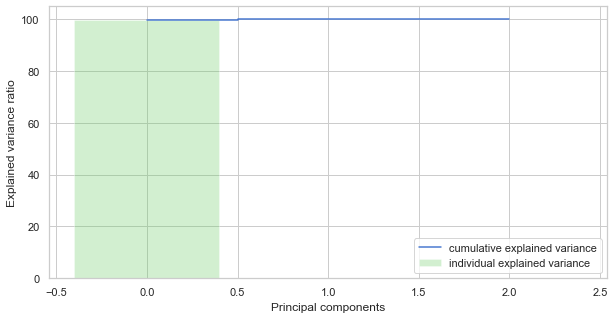

In [360]:
data = df[[ 'Close', 'Close_5d','Close_10d']]
data = data.dropna()

X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [361]:
data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
data = pca.fit_transform(data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

In [362]:
kmeans = KMeans(n_clusters=7).fit(np_scaled)
df['cluster'] = kmeans.predict(np_scaled)
df = df.reset_index()
df['principal_feature1'] = np_scaled[:,0]
df['principal_feature2'] = np_scaled[:,1]
df['cluster'].value_counts()

0    1596
6     841
1      73
2      45
4      32
3      28
5      12
Name: cluster, dtype: int64

Wir verwenden outliers_fraction, um dem Algorithmus Informationen über den Anteil der in unserem Datensatz vorhandenen Anomalien zu geben. Als Ausgangswert schätzen wir den Anteil der Ausreißer auf Basis des Kreisdiagramms auf 2.3%:

In [363]:
outliers_fraction = 0.023 # set outliers fraction based on pie chart 

Die Grundannahme bei der clusterbasierten Anomalieerkennung ist, dass, wenn wir die Daten clustern, normale Daten zu Clustern gehören, während Anomalien zu keinen Clustern oder zu kleinen Clustern gehören werden.

Im Folgenden wird der Abstand zwischen jedem Punkt und seinem nächstgelegenen Zentrum berechnet. Die größten Abstände werden als Anomalien bezeichnet.

Danach werden die Anomalien einmal in der Clusteransicht und einmal in der Zeitreihenansicht visualisiert.

<ipython-input-364-e7d814a97c20>:2: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



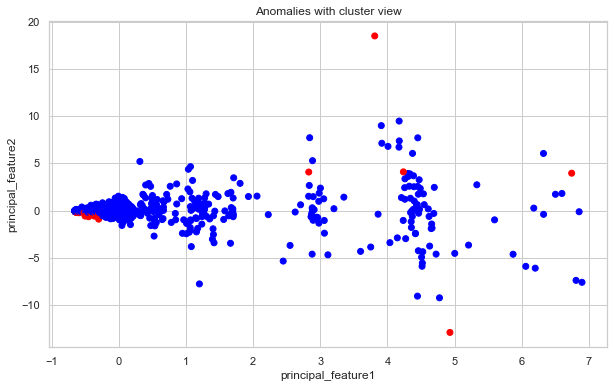

In [364]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] =  np.linalg.norm(Xa-Xb)
    return distance

distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly_km'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly_km"].apply(lambda x: colors[x]))
plt.xlabel('principal_feature1')
plt.ylabel('principal_feature2')
plt.title('Anomalies with cluster view')
plt.show();

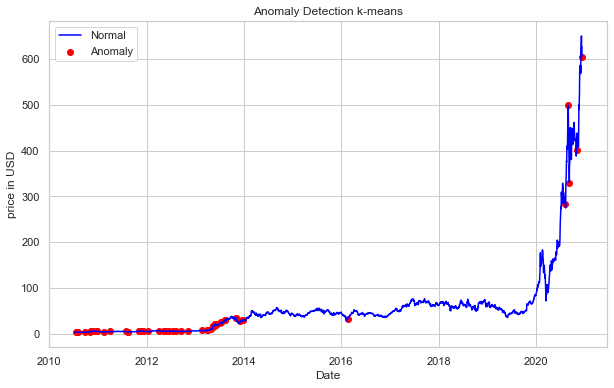

In [365]:
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_km'] == 1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label='Normal')
ax.scatter(a['Date'],a['Close'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('price in USD')
plt.legend()
plt.title('Anomaly Detection k-means')
plt.show();

<hr>

# 4. Isolation Forest

Isolation Forest basiert auf dem Entscheidungsbaum-Algorithmus. Er isoliert die Ausreißer, indem er zufällig ein Merkmal aus dem gegebenen Satz von Merkmalen auswählt und dann zufällig einen Teilungswert zwischen den Maximal- und Minimalwerten dieses Merkmals auswählt. Diese zufällige Aufteilung erzeugt kürzere Pfade in den Bäumen für die anomalen Datenpunkte und unterscheidet sie so vom Rest der Daten.


Der Algorithmus erzeugt rekursiv Partitionen auf dem Datensatz, indem es zufällig ein Merkmal auswählt und dann zufällig einen Split-Wert für das Merkmal auswählt. Vermutlich benötigen die Anomalien im Vergleich zu "normalen" Punkten im Datensatz weniger zufällige Partitionen, um isoliert zu werden, daher werden die Anomalien die Punkte sein, die eine kleinere Pfadlänge im Baum haben, wobei die Pfadlänge die Anzahl der vom Wurzelknoten aus durchlaufenen Kanten ist.

![title](isolationforest.png)

Bei der Anwendung eines IsolationForest-Modells setzen wir contamination = outliers_fraction, d. h. wir teilen dem Modell mit, dass der Anteil der Ausreißer im Datensatz 0.02 beträgt (äquivalent zu k-means).

fit und predict(data) führt die Ausreißererkennung auf den Daten durch und gibt 1 für normal und -1 für Anomalie zurück.

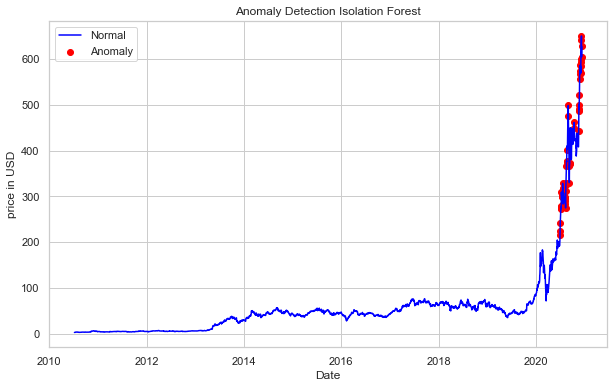

In [366]:
data = df[[ 'Close', 'Close_5d','Close_10d']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly_if'] = pd.Series(model.predict(data))

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly_if'] == -1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label = 'Normal')
ax.scatter(a['Date'],a['Close'], color='red', label = 'Anomaly')
plt.xlabel('Date')
plt.ylabel('price in USD')
plt.title('Anomaly Detection Isolation Forest')
plt.legend()
plt.show();

<hr>

# 5. Support Vector Machine

Bei der One-Class SVM wird ein Optimierungsproblem gelöst, um die Hyperebene mit dem größten Rand zu identifizieren die eine optimale Trennung der Daten der beiden Klassen ermöglicht. 

Die One-Class SVM ordnet einen neuen Punkt x der Ziel- oder der Ausreißerklasse zu, indem sie auswertet, auf welche Seite der Hyperebene er im Merkmalsraum fällt.
Um die geeignete Hyperebene zu erzeugen verwendet man die Kernel-Funktion, da man mit dieser Funktion einen linearen Klassifikator auf nicht linear klassifizierbare Daten anwenden kann.  In der Regel wird der RBF-Kernel (Gauß-Funktion) benutzt um eine nicht-lineare Grenze um den dichten Bereich des Datensatzes anzupassen, die die restlichen Punkte als Ausreißer trennt.

Eine ideale Kernel-Funktion würde die Zieldaten auf einen begrenzten, kugelförmigen Bereich im Merkmalsraum abbilden und Ausreißerbeobachtungen außerhalb dieses Bereichs. 
Sie transformiert die Daten in einen höherdimensionalen Raum und versucht somit eine bessere lineare Separierbarkeit zu erzielen.

Der geeignete Kernelparameter kann durch Minimierung des Klassifikationsfehlers gewählt werden. Außerdem sollte der Kernelparameter einen guten Kompromiss zwischen der Form der Datenstreumatrix und dem Risiko einer Überanpassung der Daten haben.
Der Hauptparameter bei dem RBF-Kernel ist der Gamma-Parameter.

Der Gamma-Parameter ist der Kehrwert der Standardabweichung des RBF-Kernels (Gauß-Funktion), der als Ähnlichkeitsmaß zwischen zwei Punkten verwendet wird. Ein kleiner Gamma-Wert definiert eine Gauß-Funktion mit einer großen Varianz. In diesem Fall können zwei Punkte als ähnlich angesehen werden, auch wenn sie weit voneinander entfernt sind, da jeder Datenpunkt einen größeren Einflussbereich hat. Ein großer Gamma-Wert, dass eine Gauß-Funktion mit einer kleinen Varianz definiert ist, und in diesem Fall werden zwei Punkte nur dann als ähnlich angesehen, wenn sie nahe beieinander liegen, das heißt der Einfluss jedes Datenpunktes sinkt.


![title](svm.png)

Bei der Anpassung des One-Class SVM-Modells legen wir wieder outliers_fraction fest, was eine obere Schranke für den Anteil der Trainingsfehler und eine untere Schranke für den Anteil der Support-Vektoren ist und zwischen 0 und 1 liegen muss. Im Grunde gibt das wieder den Anteil der Ausreißer an, den wir in unseren Daten erwarten.

kernel="rbf" gibt den Kernel-Typ an, der im Algorithmus verwendet werden soll. rbf ermöglicht der SVM die Verwendung einer nicht-linearen Funktion, um den Hyperraum auf eine höhere Dimension zu projizieren.

predict(data) führt eine Klassifizierung der Daten durch. Es wird +1 oder -1 zurückgegeben, dabei steht -1 für eine Anomalie.

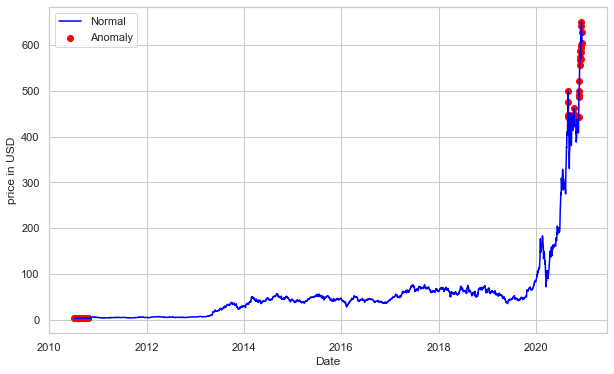

In [367]:
data = df[['Close', 'Close_5d','Close_10d']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 

model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
df['anomaly_svm'] = pd.Series(model.predict(data))

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly_svm'] == -1, ['Date', 'Close']] #anomaly

ax.plot(df['Date'], df['Close'], color='blue', label = 'Normal')
ax.scatter(a['Date'],a['Close'], color='red', label = 'Anomaly')
plt.xlabel('Date')
plt.ylabel('price in USD')
plt.legend()
plt.show();

<hr>

# 6. LSTM  (Long-Short-Term-Memory-Netze)

LSTM - Long-Short-Term-Memory-Netze wurden als Lösung für das Kurzzeitgedächtnis entwickelt. 
Sie haben interne Mechanismen, die Gates genannt werden und den Informationsfluss regulieren können.
Diese Gates können lernen, welche Daten in einer Sequenz wichtig sind und demnach behalten oder weggeworfen werden können.
Eine gewöhnliche LSTM-Einheit besteht aus einer Zelle, einem Eingangsgate, einem Ausgangsgate und einem Vergessensgate. Die Zelle merkt sich Werte über beliebige Zeitintervalle und die drei Gates regeln den Informationsfluss in und aus der Zelle.

![title](lstm1.png)

Es gibt drei Hauptkomponenten einer LSTM-Einheit:

1. Das LSTM hat eine spezielle Architektur, die es ihm ermöglicht, unnötige Informationen zu vergessen. Die Sigmoid-Schicht (σ) nimmt die Eingabe X(t) und h(t-1) (Ausgabe der letzten LSTM-Einheit) und entscheidet, welche Teile aus der alten Ausgabe entfernt werden sollen. Dieses Gate wird Vergessensgate f(t) genannt. 

2. Der nächste Schritt ist die Entscheidung und Speicherung von Informationen aus der neuen Eingabe X(t) im Zellzustand. Eine Sigmoid-Schicht entscheidet, welche der neuen Informationen aktualisiert oder ignoriert werden sollen. Eine tanh-Schicht erstellt einen Vektor mit allen möglichen Werten der neuen Eingabe. Diese werden multipliziert, um den neuen Zellzustand zu aktualisieren. Dieser neue Speicher wird dann zum alten Speicher c(t-1) addiert und ergibt c(t).

3. Schließlich müssen wir entscheiden, was wir ausgeben wollen. Eine Sigmoid-Schicht entscheidet, welche Teile des Zellzustands wir ausgeben werden. Dann lassen wir den Zellzustand durch einen tanh laufen, der alle möglichen Werte erzeugt, und multiplizieren ihn mit der Ausgabe des Sigmoid-Gatters, so dass wir nur die Teile ausgeben, für die wir uns entschieden haben.

Zunächst werden die Daten in Trainings- und Testdatensatz aufgeteilt.

In [368]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2101, 22) (526, 22)


Im nächsten Schritt Standadisieren wir die Zielvariable 'Close'

In [369]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-369-c271aeabe17a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-369-c271aeabe17a>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Bevor wir diese Daten zum Trainieren unseres Modells verwenden, müssen wir die Daten in Teilsequenzen aufteilen,
da es sich um eine Zeitreihe handelt. Wir können bestimmte Sequenzen mit bestimmten Zeitschritten erstellen. 
Nach mehrmaligem Testen haben wir uns für die Zeitschritte von 15 entschieden.
Das heißt eine Sequenz wird auf den historischen Daten der letzten 15 Tage erstellt.
<!-- #und wie von LSTM gefordert, müssen wir unsere Eingabedaten in n-fache Form und Stichprobenmerkmale umformen. In unserem Beispiel ist n-Features eins und die Zeitschritte sollen 30 sein. Das Erstellen einer separaten Funktion zum Umformen der Daten wäre hilfreich, um sie immer wieder verwenden zu können. -->



In [370]:
def create_dataset(X, y, timestep=1):
    Xs, ys = [], []
    for i in range(len(X) - timestep):
        v = X.iloc[i:(i + timestep)].values
        Xs.append(v)        
        ys.append(y.iloc[i + timestep])
    return np.array(Xs), np.array(ys)

In [371]:
print(train.shape)

time_steps = 15

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)

print(X_train.shape)

X, y = create_dataset(df[['Close']], df.Close, time_steps)


(2101, 22)
(2086, 15, 1)


Der Trainingsdatensatz besteht nun aus 2086 Sequenzen mit jeweils 15 Einträgen von einer Variablen. \
Wir halten die Zeitschritte und die Anzahl der numerischen Featurevariablen einmal fest und definieren im Anschluss das LSTM Modell.

In [372]:
timesteps = X_train.shape[1] # 15
num_features = X_train.shape[2] # 1

In [373]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


model = Sequential([
    LSTM(500, input_shape=(timesteps, num_features)), #500: Anzahl der Neuronen im Modell 
    Dropout(0.2), # wie viel Information von einem Neuron an das nächste weitergegeben wird
    RepeatVector(timesteps),
    LSTM(500, return_sequences=True),  
    Dropout(0.2), 
    TimeDistributed(Dense(num_features)) # output layer von Dimension 1           
])


model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 500)               1004000   
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)               0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 15, 500)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 15, 500)           2002000   
_________________________________________________________________
dropout_23 (Dropout)         (None, 15, 500)           0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 1)             501       
Total params: 3,006,501
Trainable params: 3,006,501
Non-trainable params: 0
___________________________________________

In [381]:
model

Nun trainieren wir das Modell auf den Trainingsdaten

In [374]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100, # Anzahl der Epochen zum Trainieren des Modells
    validation_split=0.1, # prozentualer Anteil der Trainigsdaten für die Validierung
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
59/59 [==============================] - 12s 168ms/step - loss: 0.4568 - val_loss: 0.1412
Epoch 2/100
59/59 [==============================] - 9s 150ms/step - loss: 0.2975 - val_loss: 0.1382
Epoch 3/100
59/59 [==============================] - 9s 147ms/step - loss: 0.1713 - val_loss: 0.1128
Epoch 4/100
59/59 [==============================] - 9s 147ms/step - loss: 0.1589 - val_loss: 0.0966
Epoch 5/100
59/59 [==============================] - 9s 149ms/step - loss: 0.2076 - val_loss: 0.1284
Epoch 6/100
59/59 [==============================] - 9s 150ms/step - loss: 0.2159 - val_loss: 0.0992
Epoch 7/100
59/59 [==============================] - 9s 152ms/step - loss: 0.2426 - val_loss: 0.0859
Epoch 8/100
59/59 [==============================] - 9s 149ms/step - loss: 0.2280 - val_loss: 0.0980
Epoch 9/100
59/59 [==============================] - 9s 153ms/step - loss: 0.2127 - val_loss: 0.0745
Epoch 10/100
59/59 [==============================] - 9s 150ms/step - loss: 0.2251 - val_l

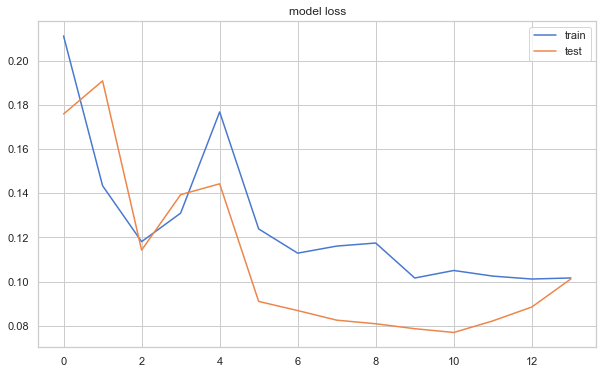

In [313]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.legend();

In [314]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 10ms/step - loss: 1.0248


1.02475905418396

Training loss:  0.16765913940472796



C:\Users\Anahita Raulin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distributuion id training loss')

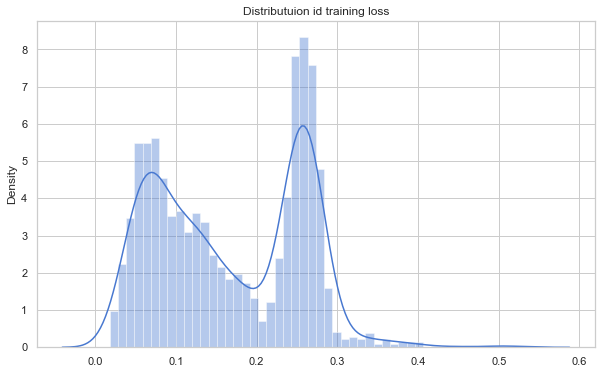

In [315]:
# plot training loss
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
avg_loss = train_mae_loss.mean()
print('Training loss: ', avg_loss); print()

plt.figure(figsize=(10,6))
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.title('Distributuion id training loss')

C:\Users\Anahita Raulin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



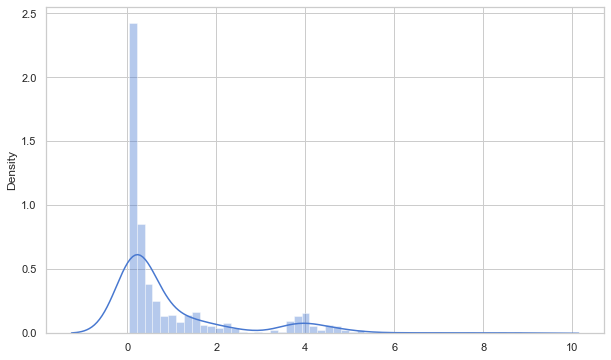

In [316]:
# plot test loss
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

plt.figure(figsize=(10,6))
sns.distplot(test_mae_loss, bins=50, kde=True);

Hier sehen wir, dass die Daten nach ca. 3 unüblich aussehen und setzen daher hier den Schwellenwert auf 3

In [317]:
THRESHOLD = 3
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly_lstm'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[time_steps:].Close


In [318]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Stock price (in USD)')

fig.update_layout(title_text="Treshold LSTM")



fig.show()

In [319]:
anomalies = test_score_df[test_score_df.anomaly_lstm == 1]

In [320]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:].Close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.Date, y=scaler.inverse_transform(anomalies.Close),
                    mode='markers',
                    name='Anomaly'))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Stock price (in USD)')

fig.update_layout(title_text="Detected Anomalies LSTM")


fig.update_layout(showlegend=True)
fig.show()

In [321]:
X_pred = model.predict(X_train)
mae_loss = np.mean(np.abs(X_pred - X_train), axis=1)
train_score_df = pd.DataFrame(train[time_steps:])
train_score_df['loss'] = mae_loss
train_score_df['threshold'] = THRESHOLD
train_score_df['anomaly_lstm'] = train_score_df.loss > train_score_df.threshold
train_score_df['Close'] = test[time_steps:].Close

anomalies = train_score_df[train_score_df.anomaly_lstm == 1]
anomalies.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,Day_Perc_Change,Trend,...,Close_10d,cluster,principal_feature1,principal_feature2,anomaly_km,anomaly_if,anomaly_svm,loss,threshold,anomaly_lstm


In dem Trainingsdatensatz befinden sich keine Anomalien, daher müssen wir diese nicht hinzufügen.

In [322]:
df = df.merge(test_score_df[['Date', 'anomaly_lstm']], how = 'left', on = 'Date')

<hr>

# 7. Vergleich der identifizierten Anomalien

In [323]:
df.anomaly_if = df.anomaly_if.replace(1, 0)
df.anomaly_if = df.anomaly_if.replace(-1, 1)

df.anomaly_svm = df.anomaly_svm.replace(1, 0)
df.anomaly_svm = df.anomaly_svm.replace(-1, 1)

df.anomaly_lstm = df.anomaly_lstm.fillna(0) 
df.anomaly_lstm = df.anomaly_lstm.replace(True, 1)

In [324]:
df['anomaly_sum'] = df.anomaly + df.anomaly_km + df.anomaly_if + df.anomaly_svm + df.anomaly_lstm

In [325]:
df['anomaly_sum'] = df.anomaly_sum.astype(int)
df['anomaly_sum'].unique()

array([2, 1, 0, 4, 3])

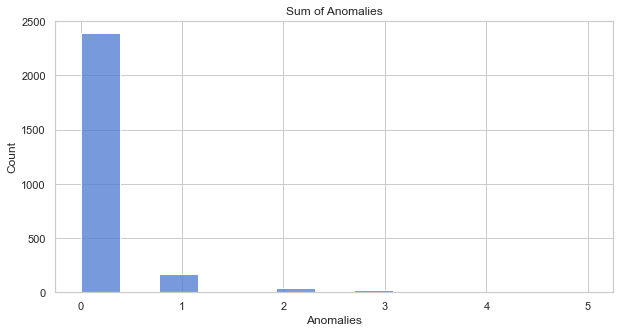

In [235]:
plt.figure(figsize = (10,5))
sns.histplot(df['anomaly_sum'])
plt.xlabel("Anomalies")
plt.title("Sum of Anomalies")
plt.xticks([0,1,2,3,4,5])
plt.show()



In [236]:
df.loc[df['anomaly_sum']>3, 'Date']

2555   2020-08-31
2556   2020-09-01
2560   2020-09-08
2611   2020-11-18
2616   2020-11-25
2617   2020-11-27
2623   2020-12-07
2624   2020-12-08
Name: Date, dtype: datetime64[ns]

### Grund für den Anstieg des Aktienkurses:

  * August 2020: Tesla führt Aktiensplit ein
      * Die Aktie wurde in Verhältnis 1:5 geteilt
      * Jeder Aktionär erhielt somit 4 weitere Anteile an der Tesla-Aktie
      
  * Dezember 2020: Aufnahme von Tesla in den S&P 500 Aktienindex

<hr>

### Quellen

https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9 \
http://colah.github.io/posts/2015-08-Understanding-LSTMs/ \
https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46 \
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 \
https://www.datacamp.com/community/tutorials/lstm-python-stock-market \
https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47 \
https://justanoderbit.com/outlier-detection/one-class-svm/ \
https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d \
https://www.electrive.net/2020/08/12/tesla-plant-aktiensplit-zum-31-august/ \
https://www.etf-nachrichten.de/was-die-aufnahme-von-tesla-in-den-sp-500-fuer-etf-anleger-bedeutet/

In [414]:
# Lefin